In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as plt
%matplotlib inline

In [2]:
# Creating DataFrame for three (3) .csv files from Snapcrack's All the News dataset
# Available here: https://www.kaggle.com/snapcrack/all-the-news
articles_1 = pd.read_csv('./data/source_data/all-the-news/articles1.csv')
articles_2 = pd.read_csv('./data/source_data/all-the-news/articles2.csv')
articles_3 = pd.read_csv('./data/source_data/all-the-news/articles3.csv')

In [3]:
# Concatenating three DataFrames into one
articles = articles_1.append(articles_2)
articles = articles.append(articles_3)

In [4]:
# Dropping unneeded columns
articles.drop(columns=['Unnamed: 0', 'id', 'author', 'date', 'year', 'month', 'url'],
              inplace=True)

In [5]:
# Creating label for outlet bias
articles['label'] = articles['publication'].map(
    {'New York Times':'establishment',
     'Breitbart':'rightwing',
     'CNN':'establishment',
     'Atlantic':'leftwing',
     'Fox News':'rightwing',
     'Talking Points Memo':'leftwing',
     'National Review':'rightwing',
     'Guardian':'leftwing',
     'Washington Post':'establishment'
    }, na_action='ignore')

In [6]:
# Dropping articles outside scope
# (NaN values would obtain for outlets excluded from mapping, above)
articles.dropna(inplace=True)

In [7]:
# Putting DataFrame in proper order
articles.rename(columns={'publication':'outlet'}, inplace=True)
articles = articles[['title','content','outlet','label']]
articles.head()

,title,content,outlet,label
0,House Republicans Fret About Winning Their Hea...,WASHINGTON — Congressional Republicans have...,New York Times,establishment
1,Rift Between Officers and Residents as Killing...,"After the bullet shells get counted, the blood...",New York Times,establishment
2,"Tyrus Wong, ‘Bambi’ Artist Thwarted by Racial ...","When Walt Disney’s “Bambi” opened in 1942, cri...",New York Times,establishment
3,"Among Deaths in 2016, a Heavy Toll in Pop Musi...","Death may be the great equalizer, but it isn’t...",New York Times,establishment
4,Kim Jong-un Says North Korea Is Preparing to T...,"SEOUL, South Korea — North Korea’s leader, ...",New York Times,establishment


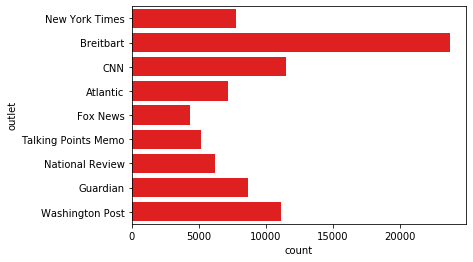

In [8]:
sns.countplot(data=articles, y='outlet', color='r');

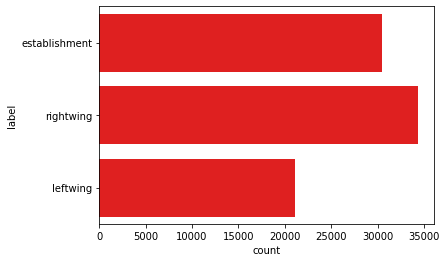

In [9]:
sns.countplot(data=articles, y='label', color='r');

In [11]:
# Importing fake news data from Megan Risdal's "Getting Real about Fake News"
fakes = pd.read_csv('./data/source_data/fake.csv')

In [12]:
# Dropping unnecessary columns
fakes.drop(columns=['uuid', 'ord_in_thread', 'author', 'published',
       'language', 'crawled', 'country', 'domain_rank',
       'thread_title', 'spam_score', 'main_img_url', 'replies_count',
       'participants_count', 'likes', 'comments', 'shares', 'type'], inplace=True)

In [13]:
# Renaming columns to align with articles DataFrame
fakes.rename(columns={'site_url':'outlet', 'text':'content'}, inplace=True)

In [14]:
# Creating a label for fake news
fakes['label'] = 'fake'

In [15]:
# Dropping NaNs for fake news DataFrame
fakes.dropna(inplace=True)

In [26]:
# Creating master DataFrame, resetting index
df = articles.append(fakes)
df.reset_index(drop=True, inplace=True)
df.shape

(98089, 4)

In [28]:
# Removing outlet names from titles, otherwise predictions would be trivial
# (e.g., New York Times article titles have this form:
# "Example Aritcle Title - The New York Times")

df['title'] = [i.split(' -')[0] for i in df['title']]

In [29]:
# Removing outlet names from CNN article bodies, otherwise predictions would be trivial
# (e.g., CNN article bodies have this form:
# "Istanbul (CNN) At least 39 people were killed...")

df['content'] = [i.split('(CNN)')[-1] for i in df['content']]

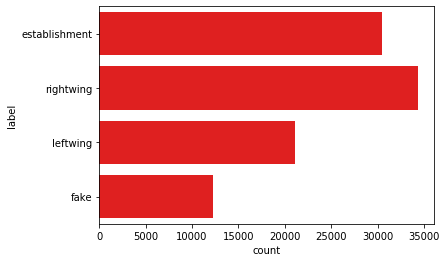

In [31]:
sns.countplot(data=df, y='label', color='r');

## Creating title and body DataFrames for multiclass classification
#### Predicting source bias from text using Count Vectorizer/TF-IDF  and Logistic Regression:
| Label         | Outlets                                       | len(title_df)| len(body_df)|
|:--------------|:---------------------------------------------:|:------------:|:-----------:|
| Establishment | New York Times \| Washington Post \| CNN      | 1500         | 150         |
| Rightwing     | Fox News \| National Review \| Breitbart      | 1500         | 150         |
| Leftwing      | Guardian \| Atlantic \| Talking Points Memo   | 1500         | 150         |
| Fake          | 241 online publications* (e.g., InfoWars)     | 1500         | 150         |

\* Fake news online publications identified by XYZ, courtesy of Megan Risdal's "Getting Real about Fake News" (https://www.kaggle.com/mrisdal/fake-news)

In [32]:
np.random.seed(42)

# Creating mini DataFrames (n=1500 per category) for title text
est_titles = pd.DataFrame(np.random.choice(df[df['label']=='establishment']['title'], 1500))
right_titles = pd.DataFrame(np.random.choice(df[df['label']=='rightwing']['title'], 1500))
left_titles = pd.DataFrame(np.random.choice(df[df['label']=='leftwing']['title'], 1500))
fake_titles = pd.DataFrame(np.random.choice(df[df['label']=='fake']['title'], 1500))

# Restoring the labels that had been removed for np.random.choice
# Label mapping: establishment: 1 | rightwing: 2 | leftwing: 3 | Fake: 4
est_titles['label'] = 1
right_titles['label'] = 2
left_titles['label'] = 3
fake_titles['label'] = 4


# Assembling DataFrame for analyzing titles
title_df = est_titles.append([right_titles,
                              left_titles,
                              fake_titles])

# Resetting index
title_df.reset_index(drop=True, inplace=True)

# Exporting to .csv
title_df.to_csv('./data/prediction_data/title_data.csv', index=False)

In [33]:
np.random.seed(42)

# Creating mini DataFrames (n=150 per category) for body text
est_body = pd.DataFrame(np.random.choice(df[df['label']=='establishment']['content'], 150))
right_body = pd.DataFrame(np.random.choice(df[df['label']=='rightwing']['content'], 150))
left_body = pd.DataFrame(np.random.choice(df[df['label']=='leftwing']['content'], 150))
fake_body = pd.DataFrame(np.random.choice(df[df['label']=='fake']['content'], 150))

# Restoring the labels that had been removed for np.random.choice
# Label mapping: establishment=1 | rightwing=2 | leftwing=3 | fake=4
est_body['label'] = 1
right_body['label'] = 2
left_body['label'] = 3
fake_body['label'] = 4

# Assembling DataFrame
body_df = est_body.append([right_body,
                           left_body,
                           fake_body])
# Resetting index
body_df.reset_index(drop=True, inplace=True)

# Exporting to .csv
body_df.to_csv('./data/prediction_data/body_data.csv', index=False)

## Creating title and body DataFrames for binary classification:
 
#### Classifying real news and fake news using Count Vectorizer/TF-IDF and Logistic Regression

| Classification | Labels included                    | len(titles_df) | len(bodies_df) | 
|:---------------|:----------------------------------:|:--------------:|:--------------:|
| Real           | Establishment<br> Rightwing<br> Leftwing | 3000           | 300            |
| Fake           | Fake                               | 3000           | 300            |

In [34]:
np.random.seed(42)

# Creating mini DataFrames for title text
est_title_bc = pd.DataFrame(np.random.choice(df[df['label']=='establishment']['title'], 1000))
right_title_bc = pd.DataFrame(np.random.choice(df[df['label']=='rightwing']['title'], 1000))
left_title_bc = pd.DataFrame(np.random.choice(df[df['label']=='leftwing']['title'], 1000))
fake_title_bc = pd.DataFrame(np.random.choice(df[df['label']=='fake']['title'], 3000))

# Restoring labels that had been removed for np.random.choice
# Label mapping: real=0 | fake=1
est_title_bc['label'] = 0
right_title_bc['label'] = 0
left_title_bc['label'] = 0
fake_title_bc['label'] = 1

# Assembling DataFrame
binary_title_df = est_title_bc.append([right_title_bc,
                                left_title_bc,
                                fake_title_bc])
# Resetting index
binary_title_df.reset_index(drop=True, inplace=True)

# Exporting to .csv
binary_title_df.to_csv('./data/prediction_data/binary_title_df.csv', index=False)

In [35]:
np.random.seed(42)

# Creating mini DataFrames for body text
est_body_bc = pd.DataFrame(np.random.choice(df[df['label']=='establishment']['content'], 100))
right_body_bc = pd.DataFrame(np.random.choice(df[df['label']=='rightwing']['content'], 100))
left_body_bc = pd.DataFrame(np.random.choice(df[df['label']=='leftwing']['content'], 100))
fake_body_bc = pd.DataFrame(np.random.choice(df[df['label']=='fake']['content'], 300))

# Restoring labels that had been removed for np.random.choice
# Label mapping: real=0 | fake=1
est_body_bc['label'] = 0
right_body_bc['label'] = 0
left_body_bc['label'] = 0
fake_body_bc['label'] = 1

# Assembling DataFrame
binary_body_df = est_body_bc.append([right_body_bc,
                                     left_body_bc,
                                     fake_body_bc])
# Resetting index
binary_body_df.reset_index(drop=True, inplace=True)

# Exporting to .csv
binary_body_df.to_csv('./data/prediction_data/binary_body_df.csv', index=False)

## Creating DataFrames of article bodies for Word2Vec analysis
#### Corpora of article bodies for each label, and one aggregate of 'real news' sources

| Classification | Labels included                    | len(bodies_df) |
|:---------------|:----------------------------------:|:--------------:|
| Real           | Establishment, Rightwing, Leftwing | 9000           |
| Fake           | Fake                               | 9000           |
| Establishment  | Establishment                      | 9000           |
| Rightwing      | Rightwing                          | 9000           |
| Leftwing       | Leftwing                           | 9000           |

In [36]:
np.random.seed(42)

# —REAL NEWS—
# Randomly selecting 'real news' article bodies for Word2Vec (9000)
mini_est_wordvec = pd.DataFrame(np.random.choice(df[df['label']=='establishment']['content'],
                                                 3000))
mini_right_wordvec = pd.DataFrame(np.random.choice(df[df['label']=='rightwing']['content'],
                                                   3000))
mini_left_wordvec = pd.DataFrame(np.random.choice(df[df['label']=='leftwing']['content'],
                                                  3000))
# Assembling corpus for 'real news' article bodies
real_wordvec = mini_est_wordvec.append([mini_right_wordvec,
                                        mini_left_wordvec])
# Resetting index
real_wordvec.reset_index(drop=True, inplace=True)
# Exporting to .csv
real_wordvec.to_csv('./data/wordvec_data/real_wordvec.csv', index=False)


# —FAKE NEWS—
# Randomly selecting 'fake news' article bodies for Word2Vec (9000)
fake_wordvec = pd.DataFrame(np.random.choice(df[df['label']=='fake']['content'], 9000))
# Exporting to .csv
fake_wordvec.to_csv('./data/wordvec_data/fake_wordvec.csv', index=False)


# —ESTABLISHMENT—
# Randomly selecting 'establishment' article bodies for Word2Vec (9000)
est_wordvec = pd.DataFrame(np.random.choice(df[df['label']=='establishment']['content'], 9000))
# Exporting to .csv
est_wordvec.to_csv('./data/wordvec_data/est_wordvec.csv', index=False)


# —RIGHTWING—
# Randomly selecting 'rightwing' article bodies for Word2Vec (9000)
right_wordvec = pd.DataFrame(np.random.choice(df[df['label']=='rightwing']['content'], 9000))
# Exporting to .csv
right_wordvec.to_csv('./data/wordvec_data/right_wordvec.csv', index=False)


# —LEFTWING—
# Randomly selecting 'leftwing' article bodies for Word2Vec (9000)
left_wordvec = pd.DataFrame(np.random.choice(df[df['label']=='leftwing']['content'], 9000))
# Exporting to .csv
left_wordvec.to_csv('./data/wordvec_data/left_wordvec.csv', index=False)